In [1]:
import os
import glob
import torch
import numpy as np
import pandas as pd
from PIL import Image
import os.path as osp
from numpy import mean
import matplotlib.pyplot as plt
from torch.utils import data
from torch.autograd import Variable
from torchvision import datasets, transforms, models

# Dataset Loader

In [2]:
class LoadImageDataset(data.Dataset):
    def __init__(self, df_path, root_dir, transform=None):
        self.data = pd.read_csv(df_path)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.data.iloc[index, 0])
        image = Image.open(img_path).convert('L')
        y_label = torch.tensor(int(self.data.iloc[index, 1]))
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, y_label

## Experiment 1 on Dataset_C with given Hyperparameter,
### Batch_size = 20, Number of Iterations = 20000,  Learning Rate = 0.01, 6 Hidden Layer, 200 Unit Per Layer, Tanh Activation

In [3]:
batch_size = 20
num_iters = 20000
input_dim = 180 * 180 #num_features = 32400
output_dim = 10
learning_rate = 0.01
num_nodes_in_hidden_layers = 200
num_hidden_layers = 6
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

mean = [0.5,]
std = [0.5, ]
#Load Dataset
train_transform = transforms.Compose([transforms.Resize(180), transforms.ToTensor(), transforms.Normalize(mean, std)])
dataset  = LoadImageDataset(df_path = 'Dataset_C/training_minimized.csv', root_dir = 'Dataset_C/training-c', transform=train_transform)

# Split Dataset
dataset_length = len(dataset)
# indices = list(range(dataset_size))
train_dataset_length = int(dataset_length*.8)
test_dataset_length = dataset_length - train_dataset_length
train_dataset, test_dataset = data.random_split(dataset, lengths=[train_dataset_length, test_dataset_length])
print('Train dataset length: ',len(train_dataset))
print('Test dataset length: ',len(test_dataset))

num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)  
print(len(train_loader));
print(len(test_loader));

cuda:0
Train dataset length:  19438
Test dataset length:  4860
972
243


### 6 Hidden Layer NN, 200 Unit per Layer, Tanh

In [4]:
import torch.nn as nn;
class NeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.tanh_1 = nn.Tanh()

        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.tanh_2 = nn.Tanh()

        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.tanh_3 = nn.Tanh()

        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.tanh_4 = nn.Tanh()

        self.linear_5 = nn.Linear(num_hidden, num_hidden)
        self.tanh_5 = nn.Tanh()

        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.tanh_6 = nn.Tanh()

        ### Output layer
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        # Linear layer
        out  = self.linear_1(x)
        out = self.tanh_1(out)

        out  = self.linear_2(out)
        out = self.tanh_2(out)

        out  = self.linear_3(out)
        out = self.tanh_3(out)

        out  = self.linear_4(out) 
        out = self.tanh_4(out)

        out  = self.linear_5(out)
        out = self.tanh_5(out)

        out  = self.linear_6(out)
        out = self.tanh_6(out)

        probas  = self.linear_out(out)
        return probas

In [5]:
model = NeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_nodes_in_hidden_layers)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

C:\Users\faisa\Dev\Tools\anaconda3\envs\pyTorch190\lib\site-packages\torch\cuda\__init__.py:83: UserWarning: 
    Found GPU%d %s which is of cuda capability %d.%d.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is %d.%d.
    
  warnings.warn(old_gpu_warn.format(d, name, major, minor, min_arch // 10, min_arch % 10))


In [6]:
iter = 0
perf_measure = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader): 
        images = images.view(-1, 180*180).to(device)
        labels = labels.to(device) 
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad() 
        # Forward pass to get output/logits
        outputs = model(images)  
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels) 
        # Getting gradients w.r.t. parameters
        loss.backward() 
        # Updating parameters
        optimizer.step() 
        iter += 1 
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:               
                images = images.view(-1, 180*180).to(device) 
                # Forward pass only to get logits/output
                outputs = model(images) 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1) 
                # Total number of labels
                total += labels.size(0) 
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum() 
            accuracy = 100 * correct.item() / total 
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
            perf_measure.append([iter, loss.item(), accuracy])

Iteration: 500. Loss: 2.3015964031219482. Accuracy: 10.59670781893004
Iteration: 1000. Loss: 2.300528049468994. Accuracy: 15.637860082304528
Iteration: 1500. Loss: 2.3026766777038574. Accuracy: 9.91769547325103
Iteration: 2000. Loss: 2.2976105213165283. Accuracy: 13.724279835390947
Iteration: 2500. Loss: 2.3120803833007812. Accuracy: 19.876543209876544
Iteration: 3000. Loss: 2.3490164279937744. Accuracy: 10.88477366255144
Iteration: 3500. Loss: 2.121997594833374. Accuracy: 13.292181069958847
Iteration: 4000. Loss: 2.155241012573242. Accuracy: 24.382716049382715
Iteration: 4500. Loss: 2.128920793533325. Accuracy: 16.48148148148148
Iteration: 5000. Loss: 2.1931750774383545. Accuracy: 24.320987654320987
Iteration: 5500. Loss: 1.9128639698028564. Accuracy: 12.510288065843621
Iteration: 6000. Loss: 2.176816940307617. Accuracy: 28.868312757201647
Iteration: 6500. Loss: 2.176396369934082. Accuracy: 28.786008230452676
Iteration: 7000. Loss: 2.0526347160339355. Accuracy: 32.489711934156375
Iter

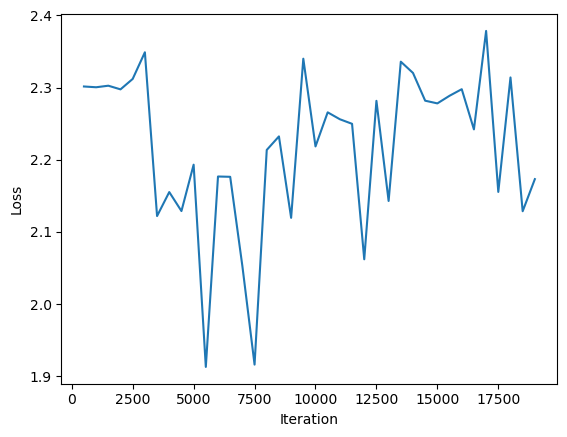

In [7]:
iteration = [i[0] for i in perf_measure]
loss = [i[1] for i in perf_measure]
plt.plot(iteration,loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.savefig('Exp1.png')
plt.show()

## Experiment 1 on Dataset_2 with given Hyperparameter,
### Batch_size = 20, Number of Iterations = 20000,  Learning Rate = 0.01, 6 Hidden Layer, 200 Unit Per Layer, Tanh Activation

In [6]:
batch_size = 20
num_iters = 20000
input_dim = 28 * 28 #num_features = 32400
output_dim = 10
learning_rate = 0.01
num_nodes_in_hidden_layers = 200
num_hidden_layers = 6
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

train_set = datasets.FashionMNIST(root = './data', train = True, transform = transforms.ToTensor(), download = True)
test_set = datasets.FashionMNIST(root = './data', train = False, transform = transforms.ToTensor())

num_epochs = num_iters / (len(train_set) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset = train_set, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_set, batch_size = batch_size, shuffle = False)

cuda:0


In [7]:
import torch.nn as nn;
class NeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.tanh_1 = nn.Tanh()

        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.tanh_2 = nn.Tanh()

        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.tanh_3 = nn.Tanh()

        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.tanh_4 = nn.Tanh()

        self.linear_5 = nn.Linear(num_hidden, num_hidden)
        self.tanh_5 = nn.Tanh()

        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.tanh_6 = nn.Tanh()

        ### Output layer
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        # Linear layer
        out  = self.linear_1(x)
        out = self.tanh_1(out)

        out  = self.linear_2(out)
        out = self.tanh_2(out)

        out  = self.linear_3(out)
        out = self.tanh_3(out)

        out  = self.linear_4(out) 
        out = self.tanh_4(out)

        out  = self.linear_5(out)
        out = self.tanh_5(out)

        out  = self.linear_6(out)
        out = self.tanh_6(out)

        probas  = self.linear_out(out)
        return probas

In [8]:
model = NeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_nodes_in_hidden_layers)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [9]:
iter = 0
perf_measure = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader): 
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device) 
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad() 
        # Forward pass to get output/logits
        outputs = model(images)  
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels) 
        # Getting gradients w.r.t. parameters
        loss.backward() 
        # Updating parameters
        optimizer.step() 
        iter += 1 
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:               
                images = images.view(-1, 28*28).to(device) 
                # Forward pass only to get logits/output
                optimizer.zero_grad()
                outputs = model(images) 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1) 
                # Total number of labels
                total += labels.size(0) 
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum() 
            accuracy = 100 * correct.item() / total 
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
            perf_measure.append([iter, loss.item(), accuracy])

Iteration: 500. Loss: 2.171478509902954. Accuracy: 27.48
Iteration: 1000. Loss: 1.3078094720840454. Accuracy: 55.15
Iteration: 1500. Loss: 0.8769275546073914. Accuracy: 59.55
Iteration: 2000. Loss: 0.9001485705375671. Accuracy: 61.54
Iteration: 2500. Loss: 1.3193598985671997. Accuracy: 68.17
Iteration: 3000. Loss: 0.8064363598823547. Accuracy: 69.67
Iteration: 3500. Loss: 0.8330233693122864. Accuracy: 73.43
Iteration: 4000. Loss: 0.4313763678073883. Accuracy: 74.95
Iteration: 4500. Loss: 0.23600928485393524. Accuracy: 76.51
Iteration: 5000. Loss: 0.5151897668838501. Accuracy: 75.71
Iteration: 5500. Loss: 0.45364561676979065. Accuracy: 76.35
Iteration: 6000. Loss: 0.4443894922733307. Accuracy: 78.12
Iteration: 6500. Loss: 0.3432938754558563. Accuracy: 80.88
Iteration: 7000. Loss: 0.35755816102027893. Accuracy: 80.44
Iteration: 7500. Loss: 0.7193235754966736. Accuracy: 80.87
Iteration: 8000. Loss: 0.4471375346183777. Accuracy: 81.37
Iteration: 8500. Loss: 0.5303871035575867. Accuracy: 82

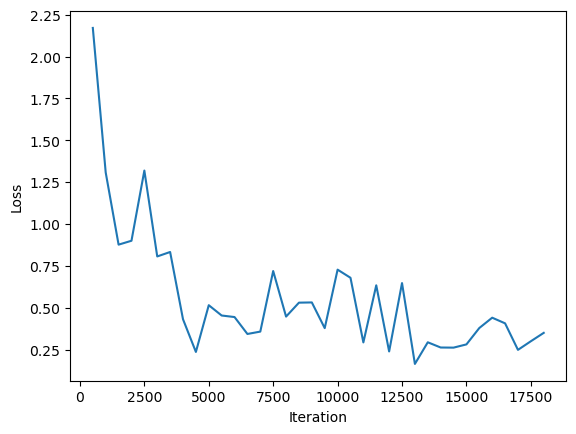

In [11]:
iteration = [i[0] for i in perf_measure]
loss = [i[1] for i in perf_measure]
plt.plot(iteration,loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.savefig('Exp1_Dataset2.png')
plt.show()